In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("taxi-analysis").getOrCreate()

22/10/04 22:13:30 WARN Utils: Your hostname, Moon-2.local resolves to a loopback address: 127.0.0.1; using 192.168.0.4 instead (on interface en0)
22/10/04 22:13:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/04 22:13:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
directory = "/Users/sig6774/Desktop/Data_Engineering/data-engineering-main/01-spark/data"
trip_file = "tripdata_2021_1-7.csv"
zone_file = "taxi+_zone_lookup.csv"

In [7]:
trips_df = spark.read.csv(f"file:///{directory}/{trip_file}", inferSchema = True, header = True)
zone_df = spark.read.csv(f"file:///{directory}/{zone_file}", inferSchema = True, header = True)

In [8]:
trips_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: double (nullable = true)



In [9]:
zone_df.printSchema()

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [10]:
# sql을 사용하기 위해 tempview 등록 
trips_df.createOrReplaceTempView("trips")
zone_df.createOrReplaceTempView("zone")

In [27]:
query = """
select 
    t.VendorId as vendor_id, 
    TO_DATE(t.tpep_pickup_datetime) as pickup_date,
    TO_DATE(t.tpep_dropoff_datetime) as dropoff_date,
    HOUR(t.tpep_pickup_datetime) as pickup_time,
    HOUR(t.tpep_dropoff_datetime) as dropoff_time,
    t.passenger_count,
    t.trip_distance,
    t.fare_amount,
    t.tip_amount,
    t.tolls_amount,
    t.total_amount,
    t.payment_type,
    pz.Zone as pickup_zone, 
    dz.Zone as dropoff_zone
from 
    trips t 
    LEFT JOIN 
        zone pz 
    ON 
        t.PULocationID = pz.LocationID
    LEFT JOIN 
        zone dz
    ON t.DOLocationID = dz.LocationID
"""

comb_df = spark.sql(query)
comb_df.createOrReplaceTempView("comb")
comb_df.show()

+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+--------------------+--------------------+
|vendor_id|pickup_date|dropoff_date|pickup_time|dropoff_time|passenger_count|trip_distance|fare_amount|tip_amount|tolls_amount|total_amount|payment_type|         pickup_zone|        dropoff_zone|
+---------+-----------+------------+-----------+------------+---------------+-------------+-----------+----------+------------+------------+------------+--------------------+--------------------+
|        1| 2021-01-01|  2021-01-01|          0|           0|            1.0|          2.1|        8.0|       0.0|         0.0|        11.8|           2| Lincoln Square East|        Central Park|
|        1| 2021-01-01|  2021-01-01|          0|           0|            1.0|          0.2|        3.0|       0.0|         0.0|         4.3|           2|Upper West Side N...|    Manhattan Valley|
|        1| 2021-01-

In [19]:
comb_df.printSchema()

root
 |-- vendor_id: integer (nullable = true)
 |-- pickup_date: date (nullable = true)
 |-- dropoff_date: date (nullable = true)
 |-- pickup_time: integer (nullable = true)
 |-- dropoff_time: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- pickup_zone: string (nullable = true)
 |-- dropoff_zone: string (nullable = true)



In [20]:
spark.sql("select pickup_date, pickup_time from comb where pickup_time >0").show()

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2020-12-31|         23|
| 2020-12-31|         21|
| 2020-12-31|         23|
| 2020-12-31|         18|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2020-12-31|         23|
| 2020-12-31|         13|
| 2020-12-31|         23|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
| 2021-01-01|          1|
+-----------+-----------+
only showing top 20 rows



In [21]:
spark.sql("select pickup_date, pickup_time from comb where pickup_date < '2020-12-31'").show()
# 이상한 데이터도 포함되어 있음 

+-----------+-----------+
|pickup_date|pickup_time|
+-----------+-----------+
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2008-12-31|         23|
| 2008-12-31|         23|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          0|
| 2009-01-01|          1|
| 2009-01-01|         17|
| 2009-01-01|         17|
| 2009-01-01|         18|
| 2009-01-01|          1|
| 2009-01-01|          1|
| 2009-01-01|          2|
| 2009-01-01|          2|
| 2009-01-01|          0|
+-----------+-----------+
only showing top 20 rows



In [24]:
comb_df.select("total_amount").describe().show()
# max와 min이 말이 안됨... 
# 클리닝 필요할 듯 

+-------+------------------+
|summary|      total_amount|
+-------+------------------+
|  count|          15000936|
|   mean|18.755400511181833|
| stddev|145.74310219085967|
|    min|            -647.8|
|    max|          398469.2|
+-------+------------------+



In [25]:
comb_df.select("trip_distance").describe().show()
# max값이 말이 안됨 

+-------+-----------------+
|summary|    trip_distance|
+-------+-----------------+
|  count|         15000936|
|   mean|6.628556730059909|
| stddev|671.7240645481055|
|    min|              0.0|
|    max|        332541.19|
+-------+-----------------+



In [28]:
comb_df.select("passenger_count").describe().show()
# 승객 수 

+-------+------------------+
|summary|   passenger_count|
+-------+------------------+
|  count|          14166908|
|   mean|1.4253582362502812|
| stddev|1.0443336003189323|
|    min|               0.0|
|    max|               9.0|
+-------+------------------+



In [30]:
query = """
select 
    DATE_TRUNC("MM", c.pickup_date) AS month, 
    COUNT(*) as trips 
from 
    comb c 

group by 
    month 
order by 
    month desc
"""
# 어떤 데이터가 가장 분포가 많은지 확인할 수 있음 
spark.sql(query).show()

+-------------------+-------+
|              month|  trips|
+-------------------+-------+
|2029-05-01 00:00:00|      1|
|2021-12-01 00:00:00|      5|
|2021-11-01 00:00:00|      5|
|2021-10-01 00:00:00|      3|
|2021-09-01 00:00:00|      3|
|2021-08-01 00:00:00|     36|
|2021-07-01 00:00:00|2821661|
|2021-06-01 00:00:00|2834204|
|2021-05-01 00:00:00|2507075|
|2021-04-01 00:00:00|2171215|
|2021-03-01 00:00:00|1925130|
|2021-02-01 00:00:00|1371689|
|2021-01-01 00:00:00|1369753|
|2020-12-01 00:00:00|     16|
|2009-01-01 00:00:00|    111|
|2008-12-01 00:00:00|     26|
|2004-04-01 00:00:00|      1|
|2003-01-01 00:00:00|      1|
|2002-12-01 00:00:00|      1|
+-------------------+-------+



### Cleaning

In [31]:
# 위에서 데이터를 확인해보면 이상한 데이터가 포함되어 있으므로 쿼리로 그것을 반영해서 진행하면 정제된 데이터를 얻을 수 있음 
query ="""
select 
    * 
from 
    comb c 
where 
    c.total_amount < 5000
    and c.total_amount > 0 
    and c.trip_distance < 100
    and c.passenger_count < 4
    and c.pickup_date >= '2021-01-01'
    and c.pickup_date < '2021-08-01'
"""

cleaned_df = spark.sql(query)
cleaned_df.createOrReplaceTempView("cleaned")

In [33]:
cleaned_df.describe().show()

+-------+-------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+
|summary|          vendor_id|       pickup_time|     dropoff_time|  passenger_count|     trip_distance|       fare_amount|        tip_amount|       tolls_amount|      total_amount|       payment_type|         pickup_zone|        dropoff_zone|
+-------+-------------------+------------------+-----------------+-----------------+------------------+------------------+------------------+-------------------+------------------+-------------------+--------------------+--------------------+
|  count|           13297341|          13297341|         13297341|         13297341|          13297341|          13297341|          13297341|           13297341|          13297341|           13297341|            13297341|            13297341|
|   mean| 1.6708780349394665

### Visualization

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [45]:
query="""
select 
    c.pickup_date, 
    count(*) as trips
from 
    cleaned c 
group by 
    c.pickup_date
"""

In [46]:
pd_df = spark.sql(query).toPandas()
# visualization을 사용해야 하기 때문에 toPandas() 함수 실행

<AxesSubplot:xlabel='pickup_date', ylabel='trips'>

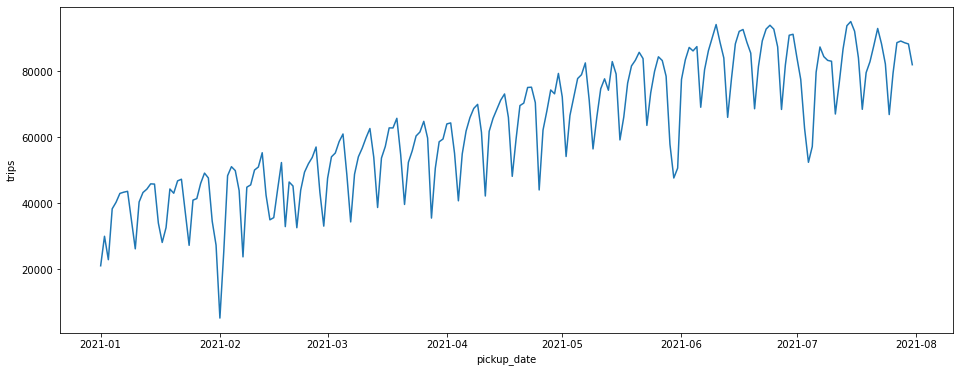

In [40]:
fig, ax = plt.subplots(figsize=(16,6))
sns.lineplot(x="pickup_date" , y="trips", data=pd_df)
# 시각화 진행 
# 코로나 시기로 인해 택시 이용 수가 꾸준히 증가하고 있으며 요일마다 패턴이 조금씩 존재 

In [48]:
query = """
SELECT 
    c.pickup_date,
    DATE_FORMAT(c.pickup_date, 'EEEE') AS day_of_week,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date,
    day_of_week
"""
pd_df2 = spark.sql(query).toPandas()

In [49]:
data = pd_df2.groupby("day_of_week").trips.median().to_frame().reset_index()
# 
data["sort_dow"] = data["day_of_week"].replace({
    "Sunday" : 0, 
    "Monday" : 1, 
    "Tuesday" : 2, 
    "Wednesday" : 3, 
    "Thursday" : 4,     
    "Friday" : 5, 
    "Saturday" : 6    
})

In [50]:
data.sort_values(by="sort_dow", inplace = True)

<AxesSubplot:xlabel='day_of_week', ylabel='trips'>

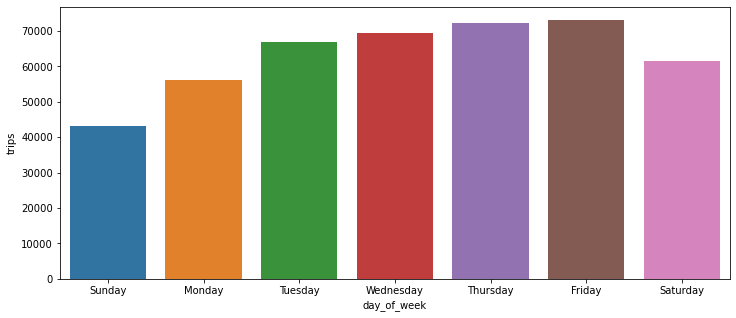

In [56]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(
    x = "day_of_week",
    y = "trips",
    data = data
)
# 요일 별 이용횟수를 볼 수 있음 

In [57]:
def get_weekday(data):
    import calendar
    return calendar.day_name(data.weekday())

spark.udf.register("get_weekday", get_weekday)
# 사용자가 정의한 함수를 sql에서도 사용할 수 있도록 


<function __main__.get_weekday(data)>

In [58]:
query = """
SELECT 
    c.pickup_date,
    get_weekday(c.pickup_date, 'EEEE') AS day_of_week,
    COUNT(*) AS trips
FROM
    cleaned c
GROUP BY
    c.pickup_date,
    day_of_week
"""


In [59]:
payment_type_to_string = {
    1: "Credit Card",
    2: "Cash",
    3: "No Charge",
    4: "Dispute",
    5: "Unknown",
    6: "Voided Trip",
}

def parse_payment_type(payment_type):
    return payment_type_to_string[payment_type]
# 숫자로된 결제 타입을 문자로 변환 

spark.udf.register("parse_payment_type", parse_payment_type)

<function __main__.parse_payment_type(payment_type)>

In [60]:
query="""
select 
    parse_payment_type(payment_type),
    count(*) AS trips, 
    MEAN(fare_amount) as mean_fare_amount,
    STD(fare_amount) as std_fare_amount
from 
    cleaned c
    
group by 
    payment_type

"""

In [61]:
spark.sql(query).show()

+--------------------------------+--------+------------------+------------------+
|parse_payment_type(payment_type)|   trips|  mean_fare_amount|   std_fare_amount|
+--------------------------------+--------+------------------+------------------+
|                     Credit Card|10118059|12.216703494217668|10.795006823047476|
|                       No Charge|   58554|11.930768862929948|15.037653917600064|
|                         Dispute|   23540|12.652123194562446|14.162625766142913|
|                            Cash| 3097187|11.981015205087699|11.474080178274454|
|                         Unknown|       1|              17.8|              null|
+--------------------------------+--------+------------------+------------------+

